In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('float_format', '{:f}'.format)

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df = pd.read_csv('glickoandprize.csv', encoding="utf-8")
df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
#df.drop_duplicates(subset=['id', 'start'], inplace=True)
#df.dropna(inplace=True)
df.prizepool = pd.to_numeric(df.prizepool, errors='coerce')
df.prizeusd = pd.to_numeric(df.prizeusd.str.replace(r'[^0-9.]', ''), errors='coerce')

In [4]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizepool.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizepool.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizepool.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizepool.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizepool.iloc[0]))

df['wdiffr'] = (df.prizepool.apply(np.log) / df.tiprize) * df.diffr

#cumulative sum of wdiffr
cumsums = df[['id', 'start', 'wdiffr']].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['id', 'start'])
df['cumuwr'] = cumsums
df = df.reset_index()
df['perf'] = df.cumuwr + df.init

In [5]:
df.sort_values('prizeusd', ascending=False)

,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,startglicko2mu,...,cumur,init,normalRating,teamrating,exp,season,tiprize,wdiffr,cumuwr,perf
12325,matumbaman,2017-08-02,12325,teamliquid,1,The International 2017,24787916.000000,1,10862683.000000,2052.390485,...,-23.429060,1761.587692,1738.158632,1811.303475,29,ti7,17.025867,24.318035,-9.051360,1752.536331
12326,miracle,2017-08-02,12326,teamliquid,2,The International 2017,24787916.000000,1,10862683.000000,2052.390485,...,17.060982,1770.054962,1787.115944,1799.064147,26,ti7,17.025867,24.318035,23.564653,1793.619615
12327,mind_control,2017-08-02,12327,teamliquid,3,The International 2017,24787916.000000,1,10862683.000000,2052.390485,...,-23.429060,1761.587692,1738.158632,1811.303475,27,ti7,17.025867,24.318035,-9.051360,1752.536331
12328,gh,2017-08-02,12328,teamliquid,4,The International 2017,24787916.000000,1,10862683.000000,2052.390485,...,6.023241,1817.333923,1823.357164,1790.003842,10,ti7,17.025867,24.318035,12.473405,1829.807329
12329,kuroky,2017-08-02,12329,teamliquid,5,The International 2017,24787916.000000,1,10862683.000000,2052.390485,...,368.269757,1528.312404,1896.582162,1771.697593,79,ti7,17.025867,24.318035,220.411947,1748.724352
10069,iceice,2016-08-02,10069,thewingsgaming,5,The International 2016,20770460.000000,1,9139002.000000,1937.206705,...,316.573600,1540.350904,1856.924504,1858.353907,11,ti6,16.849042,18.207742,216.993784,1757.344688
10068,y,2016-08-02,10068,thewingsgaming,4,The International 2016,20770460.000000,1,9139002.000000,1937.206705,...,316.573600,1540.350904,1856.924504,1858.353907,14,ti6,16.849042,18.207742,216.993784,1757.344688
10066,blink,2016-08-02,10066,thewingsgaming,2,The International 2016,20770460.000000,1,9139002.000000,1937.206705,...,316.573600,1540.350904,1856.924504,1858.353907,15,ti6,16.849042,18.207742,216.993784,1757.344688
10065,shadow haslink,2016-08-02,10065,thewingsgaming,1,The International 2016,20770460.000000,1,9139002.000000,1937.206705,...,316.573600,1540.350904,1856.924504,1858.353907,11,ti6,16.849042,18.207742,216.993784,1757.344688
10067,faith_bian,2016-08-02,10067,thewingsgaming,3,The International 2016,20770460.000000,1,9139002.000000,1937.206705,...,322.291212,1540.350904,1862.642116,1856.924504,11,ti6,16.849042,18.207742,221.407076,1761.757979


In [6]:
grouped = df.groupby(['team', 'tour'])

In [7]:
pf = pd.DataFrame(columns=['season', 'tour', 'start', 'team', 'prizepool', 'prizeusd', 'perf1', 'perf2', 'perf3', 'perf4', 'perf5'])
for name, group in grouped:
    try:
        perf1 = group[group.pos == 1].perf.iloc[0]
    except:
        perf1 = np.nan
    try:
        perf2 = group[group.pos == 2].perf.iloc[0]
    except:
        perf2 = np.nan
    try:
        perf3 = group[group.pos == 3].perf.iloc[0]
    except:
        perf3 = np.nan
    try:
        perf4 = group[group.pos == 4].perf.iloc[0]
    except:
        perf4 = np.nan
    try:
        perf5 = group[group.pos == 5].perf.iloc[0]
    except:
        perf5 = np.nan
    pf = pf.append({'season': group.season.iloc[0],
                    'tour': name[1],
                    'start': group.start.iloc[0],
                    'team': name[0],
                    'prizepool': group.prizepool.iloc[0],
                    'prizeusd': group.prizeusd.iloc[0],
                    'perf1': perf1,
                    'perf2': perf2,
                    'perf3': perf3,
                    'perf4': perf4,
                    'perf5': perf5 
                   }, ignore_index=True)
    
pf.prizepool = pd.to_numeric(pf.prizepool)
pf.prizeusd = pd.to_numeric(pf.prizeusd)
pf.perf1 = pd.to_numeric(pf.perf1)
pf.perf2 = pd.to_numeric(pf.perf2)
pf.perf3 = pd.to_numeric(pf.perf3)
pf.perf4 = pd.to_numeric(pf.perf4)
pf.perf5 = pd.to_numeric(pf.perf5)

In [8]:
pf.dtypes

season               object
tour                 object
start        datetime64[ns]
team                 object
prizepool           float64
prizeusd            float64
perf1               float64
perf2               float64
perf3               float64
perf4               float64
perf5               float64
dtype: object

In [9]:
len(pf)

2445

In [10]:
nt = pf.groupby('team').size().reset_index()
pf = pf[pf['team'].isin(nt[nt[0] > 5].team.unique())]

In [11]:
len(pf)

1745

In [12]:
pf = pf.dropna()
pf.prizeusd = pd.to_numeric(pf.prizeusd)
pf = pf.drop_duplicates(['team', 'start'])

In [13]:
ent = pd.DataFrame(pf.team.unique()).reset_index().rename(columns={'index': 'entity', 0: 'team'})
pf = ent.merge(pf, on='team', how='left')
pf.head()

,entity,team,season,tour,start,prizepool,prizeusd,perf1,perf2,perf3,perf4,perf5
0,0,4friendschrillee,ti3,Corsair Gaming Summer Tournament 2013,2013-06-28,10000.000000,0.000000,1431.514235,1415.703233,1391.409425,1391.409425,1391.409425
1,0,4friendschrillee,ti3,DreamHack Summer 2013,2013-06-15,46422.000000,0.000000,1427.237319,1427.237319,1427.237319,1427.237319,1427.237319
2,0,4friendschrillee,ti4,Electronic Sports World Cup 2013,2013-10-31,25000.000000,0.000000,1449.456046,1439.095493,1449.456046,1449.456046,1479.450199
3,0,4friendschrillee,ti5,Esportal Dota 2 League Invitational Tournament 1,2014-12-10,18691.472328,623.000000,1426.782769,1481.501966,1426.782769,1497.320470,1497.320470
4,0,4friendschrillee,ti4,Fragbite Masters 2013,2013-10-21,30410.000000,836.280000,1451.336206,1451.336206,1481.602710,1451.336206,1481.602710


In [14]:
pf.describe()

,entity,prizepool,prizeusd,perf1,perf2,perf3,perf4,perf5
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,27.703349,1293607.450134,99789.894425,1760.565731,1762.212696,1739.883454,1737.608332,1751.539222
std,16.479731,4247210.905929,529741.479802,184.889923,181.504048,163.979391,175.695226,182.350634
min,0.000000,4410.000000,0.000000,1354.909799,1281.650952,1250.132951,1210.722728,1285.740555
25%,13.000000,35000.000000,0.092500,1638.495458,1654.557850,1634.270983,1621.749307,1625.185023
50%,27.000000,100000.000000,7684.000000,1735.820183,1741.042451,1720.262637,1721.240550,1726.662200
75%,42.000000,271685.000000,34703.250000,1862.638544,1855.698253,1842.049127,1838.889722,1868.566176
max,57.000000,24787916.000000,10862683.000000,2275.504433,2302.498188,2189.346079,2221.721176,2197.749410


In [15]:
from linearmodels import PanelOLS 
panel_data = pf.set_index(['entity', 'start']).sort_index()
panel_data['const'] = np.e
Y = np.add(1, panel_data['prizeusd']).apply(np.log)
X = panel_data[['perf1', 'perf2', 'perf3', 'perf4', 'perf5', 'const']].apply(np.log)
mod = PanelOLS(Y, X, entity_effects=True, time_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,prizeusd,R-squared:,0.0817
Estimator:,PanelOLS,R-squared (Between):,0.4486
No. Observations:,1254,R-squared (Within):,0.0680
Date:,"Sun, May 13 2018",R-squared (Overall):,0.1315
Time:,12:00:16,Log-likelihood,-3083.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.400
Entities:,58,P-value,0.0000
Avg Obs:,21.621,Distribution:,"F(5,978)"
Min Obs:,1.0000,,
Max Obs:,77.000,F-statistic (robust):,17.400


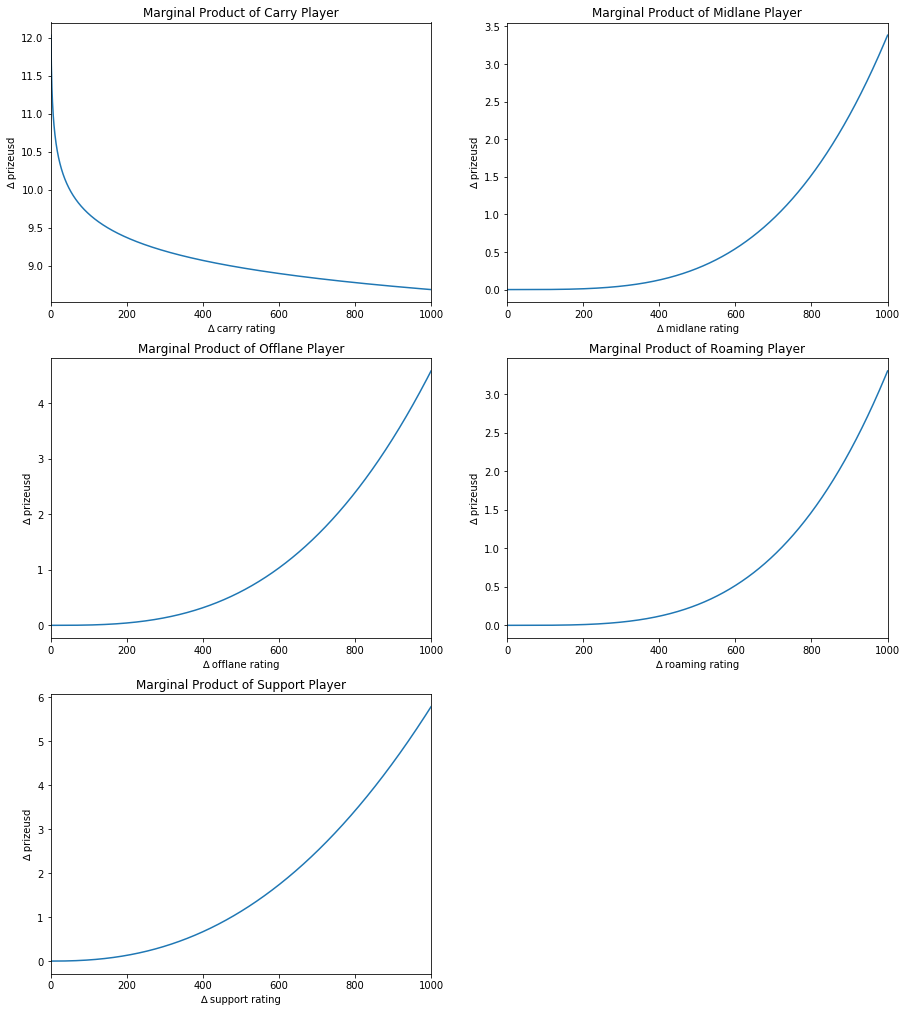

In [16]:
# create 1000 equally spaced points between -10 and 10
prizex = np.linspace(1, 1000, 2000)
carrymean = 2000**res.params.perf1
midlanermean = 2000**res.params.perf2
offlanemean = 2000**res.params.perf3
roamingmean = 2000**res.params.perf4
supportmean = 2000**res.params.perf5
# calculate the y value for each element of the x vector 
carryprize = (np.e**res.params.const) * res.params.perf1 * (prizex**(res.params.perf1 - 1)) * midlanermean * offlanemean * roamingmean * supportmean
midlanerprize = (np.e**res.params.const) * res.params.perf2 * (prizex**(res.params.perf2 - 1)) * carrymean * offlanemean * roamingmean * supportmean
offlaneprize = (np.e**res.params.const) * res.params.perf3 * (prizex**(res.params.perf3 - 1)) * midlanermean * carrymean * roamingmean * supportmean
roamingprize = (np.e**res.params.const) * res.params.perf4 * (prizex**(res.params.perf4 - 1)) * midlanermean * offlanemean * carrymean * supportmean
supportprize = (np.e**res.params.const) * res.params.perf5 * (prizex**(res.params.perf5 - 1)) * midlanermean * offlanemean * roamingmean * carrymean
fig, ax = plt.subplots(3, 2, figsize=(15, 17.5))
ax[0, 0].plot(prizex, carryprize)
ax[0, 0].set_title("Marginal Product of Carry Player")
ax[0, 0].set_ylabel("∆ prizeusd")
ax[0, 0].set_xlabel("∆ carry rating")
ax[0, 0].set_xlim(0, 1000)
ax[0, 1].plot(prizex, midlanerprize)
ax[0, 1].set_title("Marginal Product of Midlane Player")
ax[0, 1].set_ylabel("∆ prizeusd")
ax[0, 1].set_xlabel("∆ midlane rating")
ax[0, 1].set_xlim(0, 1000)
ax[1, 0].plot(prizex, offlaneprize)
ax[1, 0].set_title("Marginal Product of Offlane Player")
ax[1, 0].set_ylabel("∆ prizeusd")
ax[1, 0].set_xlabel("∆ offlane rating")
ax[1, 0].set_xlim(0, 1000)
ax[1, 1].plot(prizex, roamingprize)
ax[1, 1].set_title("Marginal Product of Roaming Player")
ax[1, 1].set_ylabel("∆ prizeusd")
ax[1, 1].set_xlabel("∆ roaming rating")
ax[1, 1].set_xlim(0, 1000)
ax[2, 0].plot(prizex, supportprize)
ax[2, 0].set_title("Marginal Product of Support Player")
ax[2, 0].set_ylabel("∆ prizeusd")
ax[2, 0].set_xlabel("∆ support rating")
ax[2, 0].set_xlim(0, 1000)
ax[2, 1].set_axis_off()

plt.show()

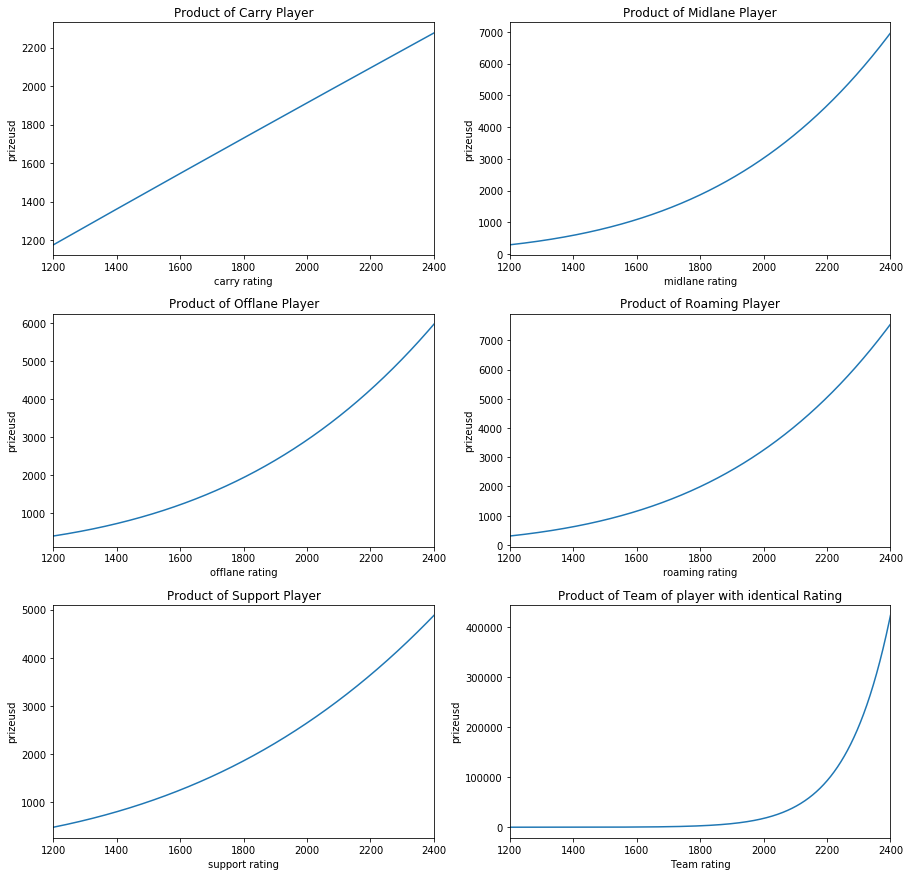

In [17]:
# create 1000 equally spaced points between -10 and 10
prizex = np.linspace(1200, 2400, 2000)
carrymean = 1760.565731**res.params.perf1
midlanermean = 1762.212696**res.params.perf2
offlanemean = 1739.883454**res.params.perf3
roamingmean = 1737.608332**res.params.perf4
supportmean = 1751.539222**res.params.perf5
# calculate the y value for each element of the x vector 
carryprize = (np.e**res.params.const) * (prizex**res.params.perf1) * midlanermean * offlanemean * roamingmean * supportmean
midlanerprize = (np.e**res.params.const) * prizex**res.params.perf2 * carrymean * offlanemean * roamingmean * supportmean
offlaneprize = (np.e**res.params.const) * prizex**res.params.perf3 * midlanermean * carrymean * roamingmean * supportmean
roamingprize = (np.e**res.params.const) * prizex**res.params.perf4 * midlanermean * offlanemean * carrymean * supportmean
supportprize = (np.e**res.params.const) * prizex**res.params.perf5 * midlanermean * offlanemean * roamingmean * carrymean
averageprize = (np.e**res.params.const) * prizex**(res.params.perf1 + res.params.perf2 + res.params.perf3 + res.params.perf4 + res.params.perf5)
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.25)
ax[0, 0].plot(prizex, carryprize)
ax[0, 0].set_title("Product of Carry Player")
ax[0, 0].set_xlim(1200, 2400)
ax[0, 0].set_ylabel("prizeusd")
ax[0, 0].set_xlabel("carry rating")
ax[0, 1].plot(prizex, midlanerprize)
ax[0, 1].set_title("Product of Midlane Player")
ax[0, 1].set_xlim(1200, 2400)
ax[0, 1].set_ylabel("prizeusd")
ax[0, 1].set_xlabel("midlane rating")
ax[1, 0].plot(prizex, offlaneprize)
ax[1, 0].set_title("Product of Offlane Player")
ax[1, 0].set_xlim(1200, 2400)
ax[1, 0].set_ylabel("prizeusd")
ax[1, 0].set_xlabel("offlane rating")
ax[1, 1].plot(prizex, roamingprize)
ax[1, 1].set_title("Product of Roaming Player")
ax[1, 1].set_xlim(1200, 2400)
ax[1, 1].set_ylabel("prizeusd")
ax[1, 1].set_xlabel("roaming rating")
ax[2, 0].plot(prizex, supportprize)
ax[2, 0].set_title("Product of Support Player")
ax[2, 0].set_xlim(1200, 2400)
ax[2, 0].set_ylabel("prizeusd")
ax[2, 0].set_xlabel("support rating")
ax[2, 1].plot(prizex, averageprize)
ax[2, 1].set_title("Product of Team of player with identical Rating")
ax[2, 1].set_xlim(1200, 2400)
ax[2, 1].set_ylabel("prizeusd")
ax[2, 1].set_xlabel("Team rating")
#ax[2, 1].set_axis_off()

plt.show()

In [24]:
pf[['entity', 'start', 'prizeusd', 'perf1', 'perf2', 'perf3', 'perf4', 'perf5']]

,entity,start,prizeusd,perf1,perf2,perf3,perf4,perf5
0,0,2013-06-28,0.000000,1431.514235,1415.703233,1391.409425,1391.409425,1391.409425
1,0,2013-06-15,0.000000,1427.237319,1427.237319,1427.237319,1427.237319,1427.237319
2,0,2013-10-31,0.000000,1449.456046,1439.095493,1449.456046,1449.456046,1479.450199
3,0,2014-12-10,623.000000,1426.782769,1481.501966,1426.782769,1497.320470,1497.320470
4,0,2013-10-21,836.280000,1451.336206,1451.336206,1481.602710,1451.336206,1481.602710
5,0,2014-04-03,0.000000,1484.302390,1429.583193,1429.583193,1429.583193,1482.149878
6,0,2014-11-13,0.000000,1482.832584,1498.651088,1428.113387,1428.113387,1498.651088
7,0,2014-01-04,0.000000,1425.361086,1425.361086,1480.080283,1425.361086,1477.927772
8,0,2013-06-19,0.000000,1402.943511,1443.048321,1402.943511,1402.943511,1402.943511
9,0,2013-05-19,0.000000,1427.464194,1427.464194,1427.464194,1427.464194,1427.464194
